In [111]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from xgboost import XGBRegressor, plot_importance
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.pipeline import Pipeline
import sys
sys.path.insert(0, '../data_prep')
from sqlite_utils import select_statement_to_df, df_to_table, table_to_df
import shap

pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_rows', 500, 'display.max_columns', 200)

In [112]:
all_features_query = """

WITH BASE_TABLE AS (
    
      SELECT
      
        a.FILM_ID
        ,c.FILM_TITLE
        ,d.FILM_GENRE
        ,e.FILM_RATING
        ,f.FILM_RATING_SCALED
        ,CASE WHEN f.FILM_RATING_SCALED IS NOT NULL THEN 1 ELSE 0 END AS RATED
      
      FROM ALL_FILMS a
      LEFT JOIN CONTENT_TYPE b
      ON a.FILM_ID = b.FILM_ID
      LEFT JOIN FILM_TITLE c
      ON a.FILM_ID = c.FILM_ID
      LEFT JOIN FILM_GENRE d
      ON a.FILM_ID = d.FILM_ID
      LEFT JOIN FILM_LETTERBOXD_STATS e
      ON a.FILM_ID = e.FILM_ID
      LEFT JOIN PERSONAL_RATING f
      ON a.FILM_ID = f.FILM_ID
      
      WHERE CONTENT_TYPE = 'movie'
      
    )
   
    SELECT

      a.FILM_ID
      ,b.FILM_TITLE
      ,c.FILM_WATCH_COUNT
      ,g.TOP_250_POSITION AS FILM_TOP_250
      ,c.FILM_RATING
      ,COALESCE(1.0*c.FILM_LIKES_COUNT/c.FILM_WATCH_COUNT, 0.0) AS LIKES_PER_WATCH
      ,COALESCE(1.0*c.FILM_FAN_COUNT/c.FILM_WATCH_COUNT, 0.0) AS FANS_PER_WATCH
      ,d.FILM_RUNTIME
      ,f.FILM_YEAR
      ,e.ALL_FILM_GENRES
    
    FROM ALL_FEATURE_FILMS a
    LEFT JOIN FILM_TITLE b
    ON a.FILM_ID = b.FILM_ID
    LEFT JOIN FILM_LETTERBOXD_STATS c
    ON a.FILM_ID = c.FILM_ID
    LEFT JOIN FILM_RUNTIME d
    ON a.FILM_ID = d.FILM_ID
    LEFT JOIN FILM_GENRE e
    ON a.FILM_ID = e.FILM_ID
    LEFT JOIN FILM_YEAR f
    ON a.FILM_ID = f.FILM_ID
    LEFT JOIN FILM_LETTERBOXD_TOP_250 g
    ON a.FILM_ID = g.FILM_ID

"""

keyword_query = """

WITH BASE_TABLE AS (
    
    SELECT
    
        a.FILM_ID
        ,c.FILM_TITLE
        ,d.KEYWORD
        ,d.KEYWORD_ID
        ,e.FILM_RATING
        ,f.FILM_RATING_SCALED
        ,CASE WHEN f.FILM_RATING_SCALED IS NOT NULL THEN 1 ELSE 0 END AS RATED
    
    FROM ALL_FEATURE_FILMS a
    LEFT JOIN CONTENT_TYPE b
    ON a.FILM_ID = b.FILM_ID
    LEFT JOIN FILM_TITLE c
    ON a.FILM_ID = c.FILM_ID
    LEFT JOIN FILM_KEYWORDS d
    ON a.FILM_ID = d.FILM_ID
    LEFT JOIN FILM_LETTERBOXD_STATS e
    ON a.FILM_ID = e.FILM_ID
    LEFT JOIN PERSONAL_RATING f
    ON a.FILM_ID = f.FILM_ID
    
    WHERE b.CONTENT_TYPE = 'movie'
    
    )
    
, SCORE_TABLE AS (

    SELECT

    KEYWORD_ID
    ,KEYWORD
    ,AVG(FILM_RATING) AS MEAN_RATING
    ,AVG(FILM_RATING_SCALED) AS MY_MEAN_RATING
    ,AVG(FILM_RATING_SCALED) - AVG(FILM_RATING) AS MY_VARIANCE
    ,((AVG(FILM_RATING_SCALED) - AVG(FILM_RATING)) * ((SUM(RATED)+0.0)/COUNT(*))) AS VARIANCE_SCORE
    ,COUNT(*) AS KEYWORD_COUNT
    ,SUM(RATED) AS MY_RATING_COUNT
    ,(SUM(RATED)+0.0)/COUNT(*) AS SCALER
    
    FROM BASE_TABLE
    
    GROUP BY KEYWORD
    
    HAVING KEYWORD_COUNT >= 30
    AND SCALER >= 0.2
    AND MY_RATING_COUNT >= 3
    --ORDER BY MEAN_RATING DESC
    --ORDER BY KEYWORD_COUNT DESC
    --ORDER BY MY_VARIANCE DESC
    --ORDER BY VARIANCE_SCORE DESC
    --ORDER BY MY_MEAN_RATING DESC
    --ORDER BY VARIANCE_SCORE DESC
)

SELECT
    a.FILM_ID
    ,a.KEYWORD_ID
    ,b.KEYWORD
    
FROM FILM_KEYWORDS a
LEFT JOIN SCORE_TABLE b
ON a.KEYWORD_ID = b.KEYWORD_ID

WHERE b.KEYWORD_ID IS NOT NULL

"""

my_rating_query = """

    SELECT
         FILM_ID
        ,FILM_RATING_SCALED
    FROM PERSONAL_RATING

"""

director_rating_query = """

WITH BASE_TABLE AS (

    SELECT

        a.FILM_ID
        ,d.FILM_TITLE
        ,b.PERSON_ID
        ,e.PERSON_NAME AS DIRECTOR_NAME
        ,CASE WHEN c.FILM_ID IS NULL THEN 0 ELSE 1 END AS WATCHED
        ,f.FILM_RATING_SCALED
        ,CASE WHEN f.FILM_RATING_SCALED IS NULL THEN 0 ELSE 1 END AS RATED

    FROM ALL_FEATURE_FILMS a

    LEFT JOIN FILM_CREW b
    ON a.FILM_ID = b.FILM_ID

    LEFT JOIN WATCHED c
    ON a.FILM_ID = c.FILM_ID

    LEFT JOIN FILM_TITLE d
    ON a.FILM_ID = d.FILM_ID

    LEFT JOIN PERSON_INFO e
    ON b.PERSON_ID = e.PERSON_ID

    LEFT JOIN PERSONAL_RATING f
    ON a.FILM_ID = f.FILM_ID

    WHERE b.JOB = 'Director'
        
    )
      
, DIRECTOR_RATINGS AS (

	SELECT
      
       PERSON_ID
	  ,DIRECTOR_NAME
      ,COUNT(*) AS TOTAL_FILMS
      ,SUM(WATCHED) AS FILMS_WATCHED
      ,AVG(WATCHED) AS PERCENT_WATCHED
      ,AVG(FILM_RATING_SCALED) AS MEAN_RATING
      ,SUM(RATED) AS FILMS_RATED
      ,AVG(RATED) AS PERCENT_RATED
      
    FROM BASE_TABLE
    
    GROUP BY PERSON_ID, DIRECTOR_NAME

    HAVING TOTAL_FILMS >= 3
    AND FILMS_WATCHED > 1
    AND FILMS_RATED > 1
    AND MEAN_RATING NOT NULL
    AND PERCENT_RATED >= .2
    
 	)
, DIRECTOR_WATCH_STATS AS (

	SELECT
      
       PERSON_ID
	  ,DIRECTOR_NAME
      ,COUNT(*) AS TOTAL_FILMS
      ,AVG(WATCHED) AS PERCENT_WATCHED
      
    FROM BASE_TABLE
    
    GROUP BY PERSON_ID, DIRECTOR_NAME
    
 	)

, MEAN_RATING AS ( SELECT AVG(MEAN_RATING)AS MEAN_TOTAL_RATING FROM DIRECTOR_RATINGS )

, FILM_DIRECTOR_LEVEL AS (

	SELECT
		
		 a.FILM_ID
		,a.FILM_TITLE
		,a.PERSON_ID
		,a.DIRECTOR_NAME
		,COALESCE(b.MEAN_RATING, (SELECT 0.8*MEAN_TOTAL_RATING FROM MEAN_RATING)) AS DIRECTOR_MEAN_RATING
		,COALESCE(c.TOTAL_FILMS, 0) AS DIRECTOR_TOTAL_FILMS
		,COALESCE(c.PERCENT_WATCHED, 0) AS DIRECTOR_PERCENT_WATCHED
		
	 FROM BASE_TABLE a
	 LEFT JOIN DIRECTOR_RATINGS b 
	 ON a.PERSON_ID = b.PERSON_ID
	 LEFT JOIN DIRECTOR_WATCH_STATS c
	 ON a.PERSON_ID = c.PERSON_ID
	 
	 )
	 
SELECT
	
	 FILM_ID
	,AVG(DIRECTOR_MEAN_RATING) AS DIRECTOR_MEAN_RATING
	,AVG(DIRECTOR_TOTAL_FILMS) AS DIRECTOR_TOTAL_FILMS
	,AVG(DIRECTOR_PERCENT_WATCHED) AS DIRECTOR_PERCENT_WATCHED

FROM FILM_DIRECTOR_LEVEL

GROUP BY FILM_ID, FILM_TITLE

"""

top_actor_film_level_query = """

WITH BASE_TABLE AS (

    SELECT

        a.FILM_ID
        ,d.FILM_TITLE
        ,b.PERSON_ID
        ,e.PERSON_NAME AS ACTOR_NAME
        ,CASE WHEN c.FILM_ID IS NULL THEN 0 ELSE 1 END AS WATCHED
        ,CASE WHEN f.FILM_RATING_SCALED IS NOT NULL THEN 1 ELSE 0 END AS RATED
        ,f.FILM_RATING_SCALED

    FROM ALL_FEATURE_FILMS a
    
    LEFT JOIN FILM_CAST b
    ON a.FILM_ID = b.FILM_ID
    
    LEFT JOIN WATCHED c
    ON a.FILM_ID = c.FILM_ID
    
    LEFT JOIN FILM_TITLE d
    ON a.FILM_ID = d.FILM_ID

    LEFT JOIN PERSON_INFO e
    ON b.PERSON_ID = e.PERSON_ID

    LEFT JOIN PERSONAL_RATING f
    ON a.FILM_ID = f.FILM_ID

    WHERE e.PERSON_NAME IS NOT NULL
    
    )
    
, ACTOR_TABLE AS (

    SELECT

    PERSON_ID
    ,SUM(WATCHED) AS TOTAL_WATCHED
    
    FROM BASE_TABLE
    
    GROUP BY PERSON_ID
    
    HAVING TOTAL_WATCHED >= 20
)

SELECT
    
     a.FILM_ID
    ,a.PERSON_ID
    ,a.ACTOR_NAME
    ,1 AS ACTOR_IN_FILM
    
FROM BASE_TABLE a
INNER JOIN ACTOR_TABLE b
ON a.PERSON_ID = b.PERSON_ID

"""

def scale_col(df, column, suffix='', a=0, b=1):
    col_min = df[column].min()
    col_max = df[column].max()
    col_range = (col_max - col_min)
    df[column+suffix] = ((df[column] - col_min) / col_range) * (b - a) + a
    return df


In [113]:
def get_valid_cols(film_id, shap_df, min_shap_val=0.001):
    filmid_shap_df = shap_df[shap_df['FILM_ID']==film_id].reset_index(drop=True)
    valid_cols = []
    for col in filmid_shap_df.columns:
        shap_val = filmid_shap_df[col][0]
        if isinstance(shap_val, str):
            col_valid = False
        elif np.isnan(shap_val):
            col_valid = False
        elif abs(shap_val) < min_shap_val:
            col_valid = False
        elif col == 'BASE_VALUE':
            col_valid = True
        else:
            col_valid = True
        if col_valid:
            valid_cols.append(col)
    return valid_cols

def create_dual_df(film_id, pred_df, shap_df, valid_cols):
    film_title = pred_df[pred_df['FILM_ID']==film_id]['FILM_TITLE'].values[0]
    dual_df = pd.concat([pred_df[pred_df['FILM_ID']==film_id], shap_df[shap_df['FILM_ID']==film_id]])
    dual_df['FILM_TITLE'] = dual_df['FILM_TITLE'].fillna(film_title)
    dual_df['ALGO_SCORE'] = dual_df['ALGO_SCORE'].fillna(dual_df['ALGO_SCORE'].max())
    dual_df = dual_df[valid_cols]
    dual_df.insert(2, 'INFO', ['FEATURE_VALUE', 'SHAP_VALUE'])
    dual_df = dual_df.reset_index(drop=True)
    return dual_df

def return_comparison_df(film_ids, min_shap_val=0.001, decimal_places=3):
    pred_df = table_to_df(table_name='FILM_ALGO_SCORE')
    shap_df = table_to_df(table_name='FILM_SHAP_VALUES')
    valid_cols = [get_valid_cols(x, shap_df, min_shap_val=min_shap_val) for x in film_ids]
    valid_cols = list(set([col for valid_col_list in valid_cols for col in valid_col_list]))
    valid_cols = ['FILM_ID', 'FILM_TITLE', 'ALGO_SCORE'] + valid_cols
    valid_cols = [x for x in pred_df.columns if x in valid_cols]
    valid_cols.append('BASE_VALUE')
    all_dfs = []
    for n, film_id in enumerate(film_ids):
        dual_df = create_dual_df(film_id, pred_df, shap_df, valid_cols)
        melted_df = pd.melt(dual_df, id_vars=['FILM_ID', 'FILM_TITLE', 'INFO'])
        pivoted_df = melted_df.drop('FILM_ID', axis=1).pivot(index='variable', columns=['FILM_TITLE', 'INFO'], values='value').reset_index()
        pivoted_df.columns = [' '.join(col) for col in pivoted_df.columns]
        if n > 0:
            pivoted_df = pivoted_df.drop('variable ', axis=1)
        all_dfs.append(pivoted_df)
    comparison_df = pd.concat(all_dfs, axis=1)
    if len(film_ids) > 1:
        comparison_df['VAR'] = comparison_df[comparison_df.columns[4]] - comparison_df[comparison_df.columns[2]]
        comparison_df['ABS_VAR'] = comparison_df['VAR'].abs()
        comparison_df = comparison_df.sort_values('ABS_VAR', ascending=False)
    else:
        comparison_df = comparison_df.sort_values(comparison_df.columns[2], ascending=False)
    return comparison_df.round(decimal_places)

def min_max_scale(arr):
    arr = np.array(arr, dtype=np.float64)
    return (arr - np.min(arr)) / (np.max(arr) - np.min(arr))

In [114]:
eligible_watchlist_df = select_statement_to_df(all_features_query)
director_rating_df = select_statement_to_df(director_rating_query)
eligible_watchlist_df = eligible_watchlist_df.merge(director_rating_df, how='left', on='FILM_ID')
eligible_watchlist_df = pd.concat([eligible_watchlist_df, eligible_watchlist_df['ALL_FILM_GENRES'].str.get_dummies(sep='/')], axis=1).drop('ALL_FILM_GENRES', axis=1)
keyword_df = select_statement_to_df(keyword_query)
keyword_df['COUNT'] = 1
keyword_df_wide = pd.pivot_table(keyword_df, values='COUNT', index=['FILM_ID'], columns=['KEYWORD']).fillna(0).reset_index()
eligible_watchlist_df = eligible_watchlist_df.merge(keyword_df_wide, how='left', on='FILM_ID')
top_actor_film_level_df = select_statement_to_df(top_actor_film_level_query)
actor_lookup_df = top_actor_film_level_df.groupby(['PERSON_ID', 'ACTOR_NAME']).count().reset_index()
actor_lookup_dict = {id:name for id, name in zip(actor_lookup_df['PERSON_ID'], actor_lookup_df['ACTOR_NAME'])}
top_actor_film_level_df_wide = pd.pivot_table(top_actor_film_level_df, values='ACTOR_IN_FILM', index=['FILM_ID'], columns='PERSON_ID').fillna(0)
top_actor_film_level_df_wide.columns = [actor_lookup_dict.get(x, x) for x in top_actor_film_level_df_wide.columns]
eligible_watchlist_df['FILM_TOP_250'] = eligible_watchlist_df['FILM_TOP_250'].fillna(266)
eligible_watchlist_df.insert(4, 'FILM_IS_TOP_250', np.where(eligible_watchlist_df['FILM_TOP_250']<=250, 1, 0))
eligible_watchlist_df = eligible_watchlist_df.merge(top_actor_film_level_df_wide, how='left', on='FILM_ID').fillna(0)
eligible_watchlist_df['FILM_RATING'] = eligible_watchlist_df['FILM_RATING'].fillna(2.0)
eligible_watchlist_df = eligible_watchlist_df.fillna(0)
my_rating_df = select_statement_to_df(my_rating_query)
rating_features_df = eligible_watchlist_df.merge(my_rating_df, how='left', on='FILM_ID')
rating_features_df['I_VS_LB'] = rating_features_df['FILM_RATING_SCALED'] - rating_features_df['FILM_RATING']
rated_features = rating_features_df[rating_features_df['FILM_RATING_SCALED'].notnull()].reset_index(drop=True)
unrated_features = rating_features_df[rating_features_df['FILM_RATING_SCALED'].isnull()].reset_index(drop=True)
rating_features_df.head()

,FILM_ID,FILM_TITLE,FILM_WATCH_COUNT,FILM_TOP_250,FILM_IS_TOP_250,FILM_RATING,LIKES_PER_WATCH,FANS_PER_WATCH,FILM_RUNTIME,FILM_YEAR,DIRECTOR_MEAN_RATING,DIRECTOR_TOTAL_FILMS,DIRECTOR_PERCENT_WATCHED,action,adventure,animation,comedy,crime,drama,family,fantasy,history,horror,music,mystery,none,romance,science-fiction,thriller,tv-movie,war,western,2000s,adventurer,aftercreditsstinger,aggressive,alien,alien life-form,amused,amusement park,android,animal horror,antagonistic,anthropomorphism,anti hero,anxious,apocalypse,archaeologist,army,artificial intelligence (a.i.),astronaut,audacious,awestruck,babysitter,baffled,based on comic,basement,bible,black magic,body horror,bold,brother brother relationship,brutality,cabin,callous,car race,cautionary,celebratory,chainsaw,church,clown,complex,computer,corpse,creature,cruelty,cyberpunk,cyborg,cynical,death game,decapitation,defiant,demon,demonic possession,desperate,disaster,disaster movie,disgusted,disturbed,doppelgänger,dracula,dramatic,duel,duringcreditsstinger,dystopia,end of the world,evil,ex-cop,excited,exhilarated,...,sign languages,slasher,sociopath,space,space marine,space opera,space travel,spacecraft,spin off,steampunk,stop motion,summer camp,superhero,superhero team,supernatural horror,supernatural power,surrealism,survival horror,suspenseful,telekinesis,telepathy,tense,time loop,time travel,tragic,transformation,treasure hunt,undead,urban legend,urban setting,victim,video nasty,villain,violence,virtual reality,virus,voodoo,voyeurism,whimsical,whodunit,winter,witch,witchcraft,witty,wizard,woods,zombie,zombie apocalypse,Harrison Ford,Tom Hanks,Bruce Willis,Gary Oldman,Johnny Depp,Cate Blanchett,Christopher Lee,Jake Gyllenhaal,Brad Pitt,Robert De Niro,Tom Cruise,Steve Buscemi,Owen Wilson,John Goodman,Scarlett Johansson,Brian Cox,Bill Murray,Matt Damon,Brendan Gleeson,Samuel L. Jackson,Nicolas Cage,Laurence Fishburne,Tilda Swinton,Liam Neeson,Christopher Walken,John Hurt,Willem Dafoe,Ralph Fiennes,Hugh Jackman,Stan Lee,John Ratzenberger,Jamie Lee Curtis,Elizabeth Banks,David Thewlis,Vin Diesel,Toby Jones,Frank Welker,Chris Evans,Josh Brolin,Michael Fassbender,Idris Elba,J.K. Simmons,Jack Angel,Alan Tudyk,Channing Tatum,Thomas Rosales Jr.,Woody Harrelson,Chris Pratt,Mickie McGowan,Sherry Lynn,FILM_RATING_SCALED,I_VS_LB
0,f_01ZLI,Jumanji,1244166,266.00,0,3.63,0.19,0.00,104.00,1995,3.22,11.00,0.36,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.65,-0.98
1,f_01UTC,Fatal Attraction,153317,266.00,0,3.46,0.17,0.00,119.00,1987,2.80,9.00,0.22,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,

In [115]:
from sklearn.model_selection import train_test_split

test_ratio = 0.05

# This first step splits into (train|dev) & test
df, df_test = train_test_split(rated_features, test_size=test_ratio, random_state=66)
df = df.sort_index().reset_index(drop=True)

print('df has {} rows and df_test has {} rows'.format(len(df), len(df_test)))
print(df_test['FILM_TITLE'].sample(10).values)

df has 1420 rows and df_test has 75 rows
['Saw V' 'Cam' "'71" 'The Cabin in the Woods'
 'The Conjuring: The Devil Made Me Do It' 'Smile'
 'Resident Evil: Retribution' 'Captain America: Civil War' 'The Ritual'
 'The Bourne Identity']


In [ ]:
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

random_state = 66

models_and_params = {
    "LinearRegression": {
        "model": LinearRegression(),
        "params": {
            # Only fit_intercept really useful here
            'reg__fit_intercept': [True, False],
            'reg__positive': [True, False],
        }
    },

    "DecisionTree": {
        "model": DecisionTreeRegressor(random_state=random_state),
        "params": {
            'max_depth': [3, 5, 10, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    },

    "RandomForest": {
        "model": RandomForestRegressor(random_state=random_state),
        "params": {
            'n_estimators': [10, 50, 100],
            'max_depth': [3, 5, 10, None],
            'min_samples_split': [2, 5],
        }
    },

    "HistGradientBoosting": {
        "model": HistGradientBoostingRegressor(random_state=random_state),
        "params": {
            'max_iter': [50, 100, 200],
            'max_depth': [None, 5, 10],
            'learning_rate': [0.05, 0.1]
        }
    },

    "XGBoost": {
        "model": XGBRegressor(random_state=random_state, verbosity=0),
        "params": {
            'n_estimators': [50, 100, 200],
            'max_depth': [3, 5, 10],
            'learning_rate': [0.05, 0.1],
            'subsample': [0.8, 1.0]
        }
    },

    "CatBoost": {
        "model": CatBoostRegressor(verbose=0, random_state=random_state),
        "params": {
            'iterations': [50, 100, 200],
            'depth': [4, 6, 8],
            'learning_rate': [0.05, 0.1]
        }
    }
}

In [117]:
low_percentile = np.percentile(df['I_VS_LB'], 5)
high_percentile = np.percentile(df['I_VS_LB'], 95)

# Apply Winsorization (capping)
df['I_VS_LB'] = np.clip(df['I_VS_LB'], low_percentile, high_percentile)

print(f"Clipped I_VS_LB at {low_percentile:.2f} and {high_percentile:.2f}")

Clipped I_VS_LB at -1.15 and 1.06


<AxesSubplot:xlabel='I_VS_LB', ylabel='Count'>

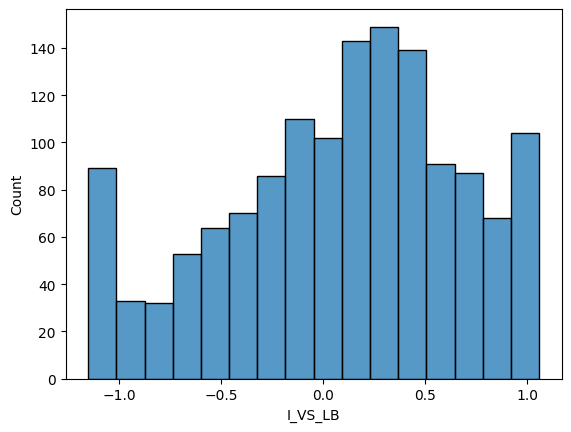

In [118]:
sns.histplot(df['I_VS_LB'])

In [131]:
class film_algo:

    def __init__(self, model, df, model_features, target, scaler=None):
        self.model = model
        self.df = df
        self.model_features = model_features
        self.target = target
        self.X = df[model_features]
        self.y = df[target]
        self.scaler = scaler
        if scaler:
            self.scaler.fit(self.X)
            self.X_scaled = pd.DataFrame(self.scaler.transform(self.X), columns=self.model_features)
        else:
            self.X_scaled = self.X
        self.model.fit(self.X_scaled, self.y)

    def run_grid_search(self, models_and_params=models_and_params, scoring=mae_scorer, cv=5):
        best_overall_score = float("inf") 
        results = {}
        best_model_info = {}
        for name, mp in models_and_params.items():
            print(f"Training {name}...")
            grid = GridSearchCV(mp["model"], mp["params"], scoring=scoring, cv=cv, n_jobs=-1)
            grid.fit(self.X_scaled, self.y)
            best_score = -grid.best_score_ 
            results[name] = {
                "best_score": -grid.best_score_,
                "best_params": grid.best_params_,
                "best_model": grid.best_estimator_,
                "grid": grid
            }
            print(f"  -> Best RMSE (neg): {-grid.best_score_:.4f}")
            if best_score < best_overall_score:
                best_overall_score = best_score
                best_model_info = {
                    "model_name": name,
                    "best_score": best_score,
                    "best_params": grid.best_params_,
                    "best_model": grid.best_estimator_
                }
        results["best_model"] = best_model_info
        return results

    def kfold_modelling(self, n_splits=5, verbose=False):
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=66)
        fold_scores = []
        for fold, (train_idx, val_idx) in enumerate(kf.split(self.X_scaled)):
            if verbose: print(f"\n--- Fold {fold + 1} ---")
            print(len(train_idx), len(val_idx))
            X_train, X_val = self.X_scaled.iloc[train_idx], self.X.iloc[val_idx]
            y_train, y_val = self.y.iloc[train_idx], self.y.iloc[val_idx]
            self.model.fit(X_train, y_train)
            score = self.score_printout(pd.concat([X_val, y_val], axis=1))
            fold_scores.append(score)
        if verbose: print('Best score was {} while mean score was {}'.format(np.min(fold_scores), np.mean(fold_scores)))
        
    def score_model(self, df=None):
        if df is not None:
            X = df[self.model_features]
            y = df[self.target]
            if self.scaler:
                X_scaled = pd.DataFrame(self.scaler.transform(X), columns=self.model_features)
            else:
                X_scaled = X
            score = self.model.score(X_scaled, y)
        else:
            score = self.model.score(self.X_scaled, self.y)
        print(score)
        return score

    def predict_model(self, df=None):
        if df is not None:
            X = df[self.model_features]
            if self.scaler:
                X_scaled = pd.DataFrame(self.scaler.transform(X), columns=self.model_features)
            else:
                X_scaled = X
            return self.model.predict(X_scaled)
        else:
            return self.model.predict(self.X_scaled)

    def model_comparison(self, df=None):
        try:
            if df is not None:
                y_truth = df[self.target]
                y_pred = self.predict_model(df=df)
                film_titles = df['FILM_TITLE']
            else:
                y_truth = self.y
                y_pred = self.predict_model()
                film_titles = self.df['FILM_TITLE']
        except:
            film_titles = []
        compare_preds_df = pd.DataFrame()
        compare_preds_df['y_truth'] = y_truth
        compare_preds_df['y_predict'] = y_pred
        compare_preds_df['error'] = (compare_preds_df['y_truth'] - compare_preds_df['y_predict'])    
        compare_preds_df['absolute_error'] = np.abs(compare_preds_df['error'])
        compare_preds_df['squared_error'] = compare_preds_df['error']**2
        compare_preds_df['percent_error'] = compare_preds_df['error']/compare_preds_df['y_truth']
        compare_preds_df['absolute_percent_error'] = np.abs(compare_preds_df['percent_error'])
        try:
            compare_preds_df.insert(0, 'FILM_TITLE', film_titles)
        except:
            pass
        self.compare_preds_df = compare_preds_df

    def plot_model_comparison(self, df=None, error_plot='error'):
        self.model_comparison(df=df)
        display(self.compare_preds_df.describe())
        display(sns.distplot(self.compare_preds_df[error_plot]))

    def scatter_predictions(self, df=None, hue_col='error'):
        self.model_comparison(df=df)
        ax = sns.scatterplot(x=self.compare_preds_df['y_truth'], y=self.compare_preds_df['y_predict'], hue=self.compare_preds_df[hue_col])
        x = np.linspace(min(self.compare_preds_df['y_truth'].min(), self.compare_preds_df['y_predict'].min()), max(self.compare_preds_df['y_truth'].max(), self.compare_preds_df['y_predict'].max()), 100)
        plt.plot(x, x, color='r', linestyle='dashed', linewidth=0.5)
        def plotlabel(xvar, yvar, label):
            ax.text(xvar+0.002, yvar, label, size=5)
        self.compare_preds_df.apply(lambda x: plotlabel(x['y_truth'],  x['y_predict'], x['FILM_TITLE']), axis=1)
        display(self.compare_preds_df.sort_values('absolute_error', ascending=False))
        display(plt.show())
    
    def score_printout(self, df=None):
        self.model_comparison(df=df)
        mae = self.compare_preds_df.describe().loc['mean', 'absolute_error']
        print('MAE = {}'.format(round(mae, 4)))
        return mae


In [132]:
model_features = df.select_dtypes(include=[np.number]).columns
target = 'I_VS_LB'
non_features = ['FILM_RATING_SCALED'] + [target]

def remove_non_features(features):
    return [x for x in features if x not in non_features]

model_features = remove_non_features(model_features)

In [133]:
simple_baseline_algo_ss = film_algo(model=LinearRegression(), df=df, model_features=model_features, target=target, scaler=StandardScaler())
simple_baseline_algo_ss.score_printout()
simple_baseline_algo_ss.score_printout(df_test)
# simple_baseline_algo_ss.kfold_modelling(6)
results = simple_baseline_algo_ss.run_grid_search()

MAE = 0.3429
MAE = 0.3972
Training LinearRegression...
  -> Best RMSE (neg): 0.4452
Training DecisionTree...
  -> Best RMSE (neg): 0.4616
Training RandomForest...
  -> Best RMSE (neg): 0.4187
Training HistGradientBoosting...
  -> Best RMSE (neg): 0.4196
Training XGBoost...
  -> Best RMSE (neg): 0.4137
Training CatBoost...
  -> Best RMSE (neg): 0.4068


In [129]:
results['best_model']

{'model_name': 'CatBoost',
 'best_score': 0.4067668482897802,
 'best_params': {'depth': 8, 'iterations': 200, 'learning_rate': 0.1},
 'best_model': <catboost.core.CatBoostRegressor at 0x17549e50310>}

In [130]:
results['CatBoost']

{'best_score': 0.4067668482897802,
 'best_params': {'depth': 8, 'iterations': 200, 'learning_rate': 0.1},
 'best_model': <catboost.core.CatBoostRegressor at 0x17549e50310>}

In [88]:
simple_baseline_algo_mm = film_algo(model=LinearRegression(), df=df, model_features=model_features, target=target, scaler=MinMaxScaler())
simple_baseline_algo_mm.score_printout()
simple_baseline_algo_mm.score_printout(df_test)
simple_baseline_algo_mm.kfold_modelling(6)

MAE = 0.3429
MAE = 0.3972

--- Fold 1 ---
1183 237
MAE = 0.459

--- Fold 2 ---
1183 237
MAE = 0.4307

--- Fold 3 ---
1183 237
MAE = 0.4552

--- Fold 4 ---
1183 237
MAE = 0.473

--- Fold 5 ---
1184 236
MAE = 0.4431

--- Fold 6 ---
1184 236
MAE = 0.4242
Best score was 0.4241810059121129 while mean score was 0.44752204043973304


In [89]:
simple_baseline_algo = film_algo(model=LinearRegression(), df=df, model_features=model_features, target=target)
simple_baseline_algo.score_printout()
simple_baseline_algo.score_printout(df_test)
simple_baseline_algo.kfold_modelling(6)

MAE = 0.3429
MAE = 0.3972

--- Fold 1 ---
1183 237
MAE = 0.459

--- Fold 2 ---
1183 237
MAE = 0.4307

--- Fold 3 ---
1183 237
MAE = 0.4552

--- Fold 4 ---
1183 237
MAE = 0.473

--- Fold 5 ---
1184 236
MAE = 0.4431

--- Fold 6 ---
1184 236
MAE = 0.4242
Best score was 0.4241810063953584 while mean score was 0.44752204063726797


In [91]:
decision_tree_algo = film_algo(model=DecisionTreeRegressor(), df=df, model_features=model_features, target=target)
decision_tree_algo.score_printout()
decision_tree_algo.score_printout(df_test)
decision_tree_algo.kfold_modelling(6)

MAE = 0.0
MAE = 0.5548

--- Fold 1 ---
1183 237
MAE = 0.5065

--- Fold 2 ---
1183 237
MAE = 0.5525

--- Fold 3 ---
1183 237
MAE = 0.5898

--- Fold 4 ---
1183 237
MAE = 0.5243

--- Fold 5 ---
1184 236
MAE = 0.5682

--- Fold 6 ---
1184 236
MAE = 0.4827
Best score was 0.48270455129057493 while mean score was 0.5373309752940417


In [92]:
decision_tree_algo_ss = film_algo(model=DecisionTreeRegressor(), df=df, model_features=model_features, target=target, scaler=StandardScaler())
decision_tree_algo_ss.score_printout()
decision_tree_algo_ss.score_printout(df_test)
decision_tree_algo_ss.kfold_modelling(6)

MAE = 0.0
MAE = 0.5681

--- Fold 1 ---
1183 237
MAE = 0.4957

--- Fold 2 ---
1183 237
MAE = 0.5377

--- Fold 3 ---
1183 237
MAE = 0.5768

--- Fold 4 ---
1183 237
MAE = 0.5378

--- Fold 5 ---
1184 236
MAE = 0.5581

--- Fold 6 ---
1184 236
MAE = 0.4806
Best score was 0.48059749900551885 while mean score was 0.5311062697614845


In [93]:
decision_tree_algo_mm = film_algo(model=DecisionTreeRegressor(), df=df, model_features=model_features, target=target, scaler=MinMaxScaler())
decision_tree_algo_mm.score_printout()
decision_tree_algo_mm.score_printout(df_test)
decision_tree_algo_mm.kfold_modelling(6)

MAE = 0.0
MAE = 0.5467

--- Fold 1 ---
1183 237
MAE = 0.5156

--- Fold 2 ---
1183 237
MAE = 0.5634

--- Fold 3 ---
1183 237
MAE = 0.5777

--- Fold 4 ---
1183 237
MAE = 0.5233

--- Fold 5 ---
1184 236
MAE = 0.5682

--- Fold 6 ---
1184 236
MAE = 0.4827
Best score was 0.4827295947066424 while mean score was 0.5384972294561278


In [95]:
xgboost_algo = film_algo(model=XGBRegressor(), df=df, model_features=model_features, target=target)
xgboost_algo.score_printout()
xgboost_algo.score_printout(df_test)
xgboost_algo.kfold_modelling(6)

MAE = 0.0988
MAE = 0.3574

--- Fold 1 ---
1183 237
MAE = 0.4113

--- Fold 2 ---
1183 237
MAE = 0.3988

--- Fold 3 ---
1183 237
MAE = 0.4326

--- Fold 4 ---
1183 237
MAE = 0.4128

--- Fold 5 ---
1184 236
MAE = 0.4236

--- Fold 6 ---
1184 236
MAE = 0.3655
Best score was 0.36545374644281886 while mean score was 0.4074282147721553


In [96]:
xgboost_algo_ss = film_algo(model=XGBRegressor(), df=df, model_features=model_features, target=target, scaler=StandardScaler())
xgboost_algo_ss.score_printout()
xgboost_algo_ss.score_printout(df_test)
xgboost_algo_ss.kfold_modelling(6)

MAE = 0.0988
MAE = 0.3574

--- Fold 1 ---
1183 237
MAE = 0.4113

--- Fold 2 ---
1183 237
MAE = 0.3988

--- Fold 3 ---
1183 237
MAE = 0.4326

--- Fold 4 ---
1183 237
MAE = 0.4128

--- Fold 5 ---
1184 236
MAE = 0.4236

--- Fold 6 ---
1184 236
MAE = 0.3655
Best score was 0.36545374644281886 while mean score was 0.4074282147721553


In [97]:
xgboost_algo_mm = film_algo(model=XGBRegressor(), df=df, model_features=model_features, target=target, scaler=MinMaxScaler())
xgboost_algo_mm.score_printout()
xgboost_algo_mm.score_printout(df_test)
xgboost_algo_mm.kfold_modelling(6)

MAE = 0.0988
MAE = 0.3574

--- Fold 1 ---
1183 237
MAE = 0.4113

--- Fold 2 ---
1183 237
MAE = 0.3988

--- Fold 3 ---
1183 237
MAE = 0.4326

--- Fold 4 ---
1183 237
MAE = 0.4128

--- Fold 5 ---
1184 236
MAE = 0.4236

--- Fold 6 ---
1184 236
MAE = 0.3655
Best score was 0.36545374644281886 while mean score was 0.4074282147721553


In [99]:
catboost_algo = film_algo(model=CatBoostRegressor(verbose=0), df=df, model_features=model_features, target=target)
catboost_algo.score_printout()
catboost_algo.score_printout(df_test)
catboost_algo.kfold_modelling(6)

MAE = 0.1978
MAE = 0.3711

--- Fold 1 ---
1183 237
MAE = 0.3931

--- Fold 2 ---
1183 237
MAE = 0.3746

--- Fold 3 ---
1183 237
MAE = 0.3936

--- Fold 4 ---
1183 237
MAE = 0.4005

--- Fold 5 ---
1184 236
MAE = 0.3904

--- Fold 6 ---
1184 236
MAE = 0.3663
Best score was 0.36625667240204135 while mean score was 0.3864089133467687


In [100]:
catboost_algo_ss = film_algo(model=CatBoostRegressor(verbose=0), df=df, model_features=model_features, target=target, scaler=StandardScaler())
catboost_algo_ss.score_printout()
catboost_algo_ss.score_printout(df_test)
catboost_algo_ss.kfold_modelling(6)

MAE = 0.1978
MAE = 0.3711

--- Fold 1 ---
1183 237
MAE = 0.3931

--- Fold 2 ---
1183 237
MAE = 0.3747

--- Fold 3 ---
1183 237
MAE = 0.3936

--- Fold 4 ---
1183 237
MAE = 0.4005

--- Fold 5 ---
1184 236
MAE = 0.3904

--- Fold 6 ---
1184 236
MAE = 0.3663
Best score was 0.36625667240204135 while mean score was 0.3864056030072774


In [101]:
catboost_algo_mm = film_algo(model=CatBoostRegressor(verbose=0), df=df, model_features=model_features, target=target, scaler=MinMaxScaler())
catboost_algo_mm.score_printout()
catboost_algo_mm.score_printout(df_test)
catboost_algo_mm.kfold_modelling(6)

MAE = 0.1978
MAE = 0.3711

--- Fold 1 ---
1183 237
MAE = 0.3931

--- Fold 2 ---
1183 237
MAE = 0.3746

--- Fold 3 ---
1183 237
MAE = 0.3936

--- Fold 4 ---
1183 237
MAE = 0.4005

--- Fold 5 ---
1184 236
MAE = 0.3904

--- Fold 6 ---
1184 236
MAE = 0.3662
Best score was 0.36623746602356394 while mean score was 0.3864057122836891


In [ ]:
tmp = pd.concat([pd.DataFrame(catboost_algo.model.feature_names_), pd.DataFrame(catboost_algo.model.feature_importances_)], axis=1)
tmp.columns = ['feature_name', 'feature_importance']
tmp.sort_values('feature_importance', ascending=False)

In [ ]:
catboost_algo.model.feat

In [ ]:
for feature in rated_features.columns:
    display(rated_features[[feature]].describe(percentiles=[.05, .25, .5, .75, .95]))

In [ ]:
rating_features_df_test = rating_features_df.copy()
lower_limit = np.percentile(rating_features_df_test["FILM_WATCH_COUNT"], 5)
upper_limit = np.percentile(rating_features_df_test["FILM_WATCH_COUNT"], 95)
print(lower_limit, upper_limit)


In [ ]:
rating_features_df_test['FILM_WATCH_COUNT_CAPPED'] = np.where(rating_features_df_test["FILM_WATCH_COUNT"] < lower_limit, lower_limit, rating_features_df_test['FILM_WATCH_COUNT'])
rating_features_df_test['FILM_WATCH_COUNT_CAPPED'] = np.where(rating_features_df_test["FILM_WATCH_COUNT"] > upper_limit, upper_limit, rating_features_df_test['FILM_WATCH_COUNT_CAPPED'])

In [ ]:
sns.histplot(rating_features_df, x='FILM_WATCH_COUNT', kde=True, color='orange')
sns.histplot(rating_features_df_test, x='FILM_WATCH_COUNT_CAPPED', kde=True, color='blue')
plt.xlim(0, 750000)

In [ ]:
def analyse_col(col_name):
    agg_df = rated_features.groupby(col_name).agg({'FILM_ID':'count', 'FILM_RATING':'mean', 'FILM_RATING_SCALED':'mean', 'I_VS_LB':'mean'})
    if len(agg_df) <= 5:
        display(agg_df)
        all_titles = list(rated_features[rated_features[col_name] == 1]['FILM_TITLE'].values)
        display(', '.join(all_titles))
        fig, ax = plt.subplots(2, 2, figsize=(10, 10))
        ax = ax.flatten()
        sns.histplot(rated_features, x='FILM_RATING_SCALED', hue=col_name, kde=True, ax=ax[0])
        sns.ecdfplot(rated_features, x='FILM_RATING_SCALED', hue=col_name, ax=ax[1])
        sns.histplot(rated_features, x='I_VS_LB', hue=col_name, kde=True, ax=ax[2])
        sns.ecdfplot(rated_features, x='I_VS_LB', hue=col_name, ax=ax[3])
    else:
        display(rated_features[[col_name]].describe(percentiles=[0.01, 0.05, 0.1, 0.9, 0.95, 0.99]))
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        ax = ax.flatten()
        sns.histplot(rating_features_df, x=col_name, kde=True, ax=ax[0])
        sns.ecdfplot(rating_features_df, x=col_name, ax=ax[1])

In [ ]:
basic_rating_df = select_statement_to_df('SELECT * FROM PERSONAL_RATING')
basic_rating_df['FILM_RATING_BASIC'].plot(kind='hist', bins=10)

In [ ]:
pd.DataFrame(basic_rating_df['FILM_RATING_BASIC'].value_counts()).reset_index().sort_values('index')[['FILM_RATING_BASIC']].plot(kind='bar')
pd.DataFrame(basic_rating_df['FILM_RATING_BASIC'].value_counts()).reset_index().sort_values('index')

In [ ]:
analyse_col('science-fiction')

In [ ]:
analyse_col('FILM_WATCH_COUNT')

In [ ]:
sns.histplot(rating_features_df, x='FILM_WATCH_COUNT', kde=True)
sns.histplot(unrated_features, x='FILM_WATCH_COUNT', kde=True)

In [ ]:
non_features = ['FILM_ID',
                'FILM_TITLE',
                # 'FILM_RATING',
                'FILM_RATING_SCALED',
                'FILM_RUNTIME',
                'FILM_WATCH_COUNT',
                'FILM_FAN_COUNT',
                'FILM_YEAR',
                'FILM_TOP_250',
                # 'DIRECTOR_MEAN_RATING',
                # 'DIRECTOR_TOTAL_FILMS',
                # 'DIRECTOR_PERCENT_WATCHED',
                'new jersey',
                'philadelphia, pennsylvania',
                'I_VS_LB'
                ]
model_features = [x for x in unrated_features.columns if x not in non_features]
delete_cols = []
for col in model_features:
    col_mean = rated_features[col].mean()
    if len(rated_features[col].unique()) == 2 and col_mean < .01:
        delete_cols.append(col)
print(delete_cols)
model_features = [x for x in model_features if x not in delete_cols]
target = 'I_VS_LB'
X_train = rated_features[model_features]
y_train = rated_features[[target]]
y_train = np.clip(y_train, np.percentile(y_train, 1), np.percentile(y_train, 99))
# y_train = np.square(y_train)
print('Data gathering complete!')
print('Scaling features...')
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
print('Features Scaled!')
print('Training model...')
valid_model_types = ['xgboost', 'decision_tree', 'linear_regression']
model_type = 'xgboost'
if model_type == 'xgboost':
    model = XGBRegressor(min_child_weight=5)
elif model_type == 'decision_tree':
    model = DecisionTreeRegressor(min_samples_leaf=5)
elif model_type == 'linear_regression':
    model = LinearRegression()
model.fit(X_train, y_train)
print('Model train complete!')
print('Making predictions...')
X_pred = unrated_features[model_features]
X_pred = scaler.transform(X_pred)
pred_df = unrated_features.copy()
pred_df[target+'_PRED'] = model.predict(X_pred)
# pred_df['FILM_RATING_PRED'] = np.sqrt(model.predict(X_pred))
print('Predictions complete!')
pred_df['FILM_RATING_PRED'] = pred_df['FILM_RATING'] + pred_df[target+'_PRED']
pred_df = scale_col(pred_df, 'FILM_RATING_PRED', a=0, b=5)
# pred_df = scale_col(pred_df, target+'_PRED', a=0, b=1)
model.score(X_train, y_train)

In [ ]:
sns.distplot(y_train)

In [ ]:
y_train_ = min_max_scale(y_train.iloc[:, 0].values)
y_train_log = np.log(y_train_)

y_train_squared = np.square(y_train_)

from scipy.stats import boxcox
y_train_boxcox, lambda_ = boxcox(1+y_train_)

from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer(method='yeo-johnson')
y_train_transformed_pt = pt.fit_transform(y_train_.reshape(-1, 1))

sns.distplot(min_max_scale(y_train_), color='red')
# sns.distplot(min_max_scale(y_train_squared), color='blue')
# sns.distplot(min_max_scale(y_train_log), color='green')
# sns.distplot(min_max_scale(y_train_boxcox), color='grey')
sns.distplot(min_max_scale(y_train_transformed_pt), color='orange')

In [ ]:
# pred_df.sort_values(target+'_PRED', ascending=False).tail(50)
pred_df.sort_values('FILM_RATING_PRED', ascending=False).head(50)

In [ ]:
plt.scatter(data=pred_df[pred_df['FILM_RATING']>0], x='I_VS_LB_PRED', y='FILM_RATING_PRED', c='FILM_RATING')

In [ ]:
plt.hist(pred_df['I_VS_LB_PRED'], color='blue', density=True, histtype='step')
plt.hist(y_train, color='red', density=True, histtype='step')

In [ ]:
pred_df.sort_values('I_VS_LB_PRED', ascending=False).head(50)

In [ ]:
final_df = pd.concat([pred_df, rated_features], axis=0).reset_index(drop=True)
print('Calculating SHAP values...')
if model_type == 'xgboost' or model_type == 'decision_tree':
    explainer = shap.TreeExplainer(model, X_train)
elif model_type == 'linear_regression':
    explainer = shap.LinearExplainer(model, X_train)
# shap_values = explainer.Explainer(X_pred)
shap_values = explainer.shap_values(X_pred)
explainer_df = pd.DataFrame(shap_values, columns=model_features)
explainer_df.insert(0, 'FILM_ID', pred_df['FILM_ID'])

In [ ]:
explainer2 = shap.TreeExplainer(model, feature_names=model_features)
explanation = explainer2(X_pred)
shap_values2 = explainer2.shap_values(X_pred)

In [ ]:
X_pred.shape

In [ ]:
shap.initjs()
shap.force_plot(explainer2.expected_value, shap_values2[0, :], X_pred[0])

In [ ]:
shap.plots.beeswarm(explanation)

In [ ]:
tmp_film_id = 'f_0J1hQ'
tmp = explainer_df[explainer_df['FILM_ID']==tmp_film_id].drop('FILM_ID', axis=1)
tmp2 = tmp.loc[:, (abs(tmp) > 0.01).any(axis=0)].T.reset_index()
tmp2.columns = ['col_name', 'col_shap']
tmp3 = unrated_features[unrated_features['FILM_ID']==tmp_film_id].T.reset_index()
tmp3.columns = ['col_name', 'col_val']
tmp4 = tmp3.merge(tmp2, how='inner', on='col_name')
tmp4.sort_values('col_shap')

In [ ]:
# explainer_df.columns = [x+'_SHAP' if x != 'FILM_ID' else x for x in explainer_df.columns]
explainer_df

In [ ]:
pred_df

In [ ]:
def visualise_shap_for_feature(feature_name):
    if feature_name in [x for x in explainer_df.columns if x != 'FILM_ID']:
        values = pred_df[feature_name]
        shaps = explainer_df[feature_name]
        plt.scatter(x=values, y=shaps)
    else:
        print('Choose a Feature Used in the model')

In [ ]:
[x for x in explainer_df.columns if x != 'FILM_ID']

In [ ]:
visualise_shap_for_feature('DIRECTOR_PERCENT_WATCHED')

In [ ]:
plt.scatter(data=explainer_df, x='FILM_WATCH_COUNT', y='DIRECTOR_PERCENT_WATCHED')

In [ ]:
pred_df.sort_values('FILM_RATING_PRED')

In [ ]:
ex

In [ ]:

# import ipdb; ipdb.set_trace()
try:
    ex = explainer.expected_value[0]
except:
    ex = explainer.expected_value
explainer_df.insert(1, 'BASE_VALUE', ex)
explainer_df['PREDICTION'] = explainer_df.sum(axis=1)
explainer_df = explainer_df.merge(pred_df[['FILM_ID', 'ALGO_SCORE']], how='left', on='FILM_ID')
explainer_df['SCALER'] = explainer_df['ALGO_SCORE'] / explainer_df['PREDICTION']
explainer_df = explainer_df.drop('FILM_ID', axis=1).mul(explainer_df['SCALER'], axis=0).drop(['ALGO_SCORE', 'SCALER'], axis=1) 
explainer_df.insert(0, 'FILM_ID', pred_df['FILM_ID'])
explainer_df = explainer_df.loc[:, (explainer_df != 0).any(axis=0)]
print('SHAP values calculated!')

In [ ]:
X_train